# Mercari Price Suggestion Challenge
* url: https://www.kaggle.com/c/mercari-price-suggestion-challenge

### import module

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from collections import Counter, defaultdict
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
import scipy

import gc

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import helper_function as helper

### data exploration

In [2]:
train = pd.read_csv('sample_data/train.tsv', sep='\t')
test = pd.read_csv('sample_data/test.tsv', sep='\t')
submission = pd.read_csv('sample_data/sample_submission.csv', sep=',')

In [3]:
# train = pd.read_csv('data/train.tsv', sep='\t')
# test = pd.read_csv('data/test.tsv', sep='\t')

In [4]:
train.head(3)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [5]:
submission.head(3)

,test_id,price
0,0,26.738
1,1,26.738
2,2,26.738


In [6]:
train.shape

(999, 8)

In [7]:
train.describe()

,train_id,item_condition_id,price,shipping
count,999.000000,999.000000,999.000000,999.000000
mean,499.000000,1.887888,27.899900,0.450450
std,288.530761,0.916036,45.887092,0.497788
min,0.000000,1.000000,3.000000,0.000000
25%,249.500000,1.000000,10.000000,0.000000
50%,499.000000,2.000000,16.000000,0.000000
75%,748.500000,3.000000,29.000000,1.000000
max,998.000000,5.000000,650.000000,1.000000


In [8]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

### Price
* log_price = <b>Log2( price+1 )</b>
* log_price_slot = ceil( <b>Log2( price+1 )</b> )

In [9]:
price = DataFrame(train['price'])
price['log_price'] = list(helper.log(train.price))
price['log_price_slot'] = list(helper.log(train.price, slot=True))
price.head(3)

,price,log_price,log_price_slot
0,10.0,3.459432,4
1,52.0,5.727920,6
2,10.0,3.459432,4


In [10]:
price['log_price_slot'].value_counts()

4     372
5     314
6     152
3      81
7      45
8      14
2      14
9       5
10      2
Name: log_price_slot, dtype: int64

### Pricing and Item Condition ID

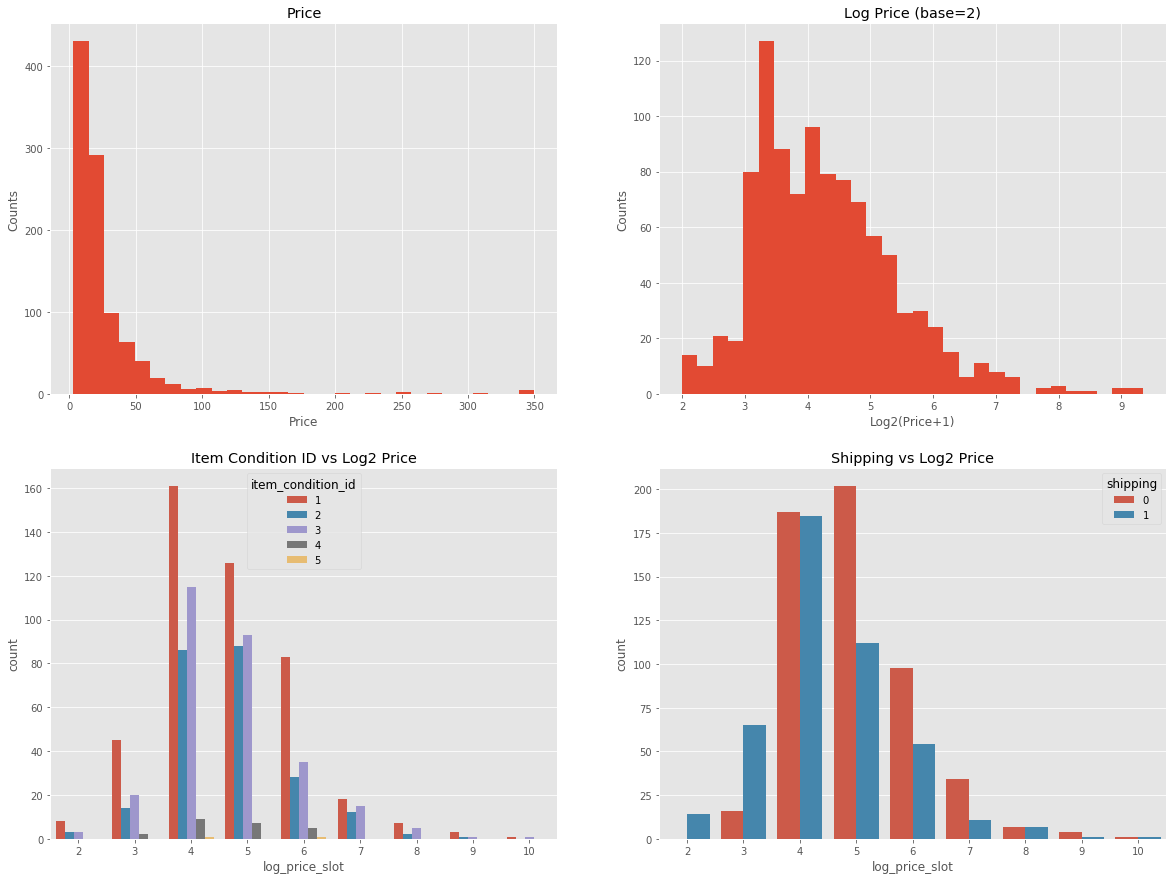

In [11]:
f,ax=plt.subplots(2,2,figsize=(20,15))

ax[0,0].hist(list(helper.price_scale(train.price, n=350)), bins = 30,label = 'price')
ax[0,0].set_title("Price")
ax[0,0].set_xlabel("Price")
ax[0,0].set_ylabel("Counts")

ax[0,1].hist('log_price', bins = 30,label='price', data=price)
ax[0,1].set_title("Log Price (base=2)")
ax[0,1].set_xlabel("Log2(Price+1)")
ax[0,1].set_ylabel("Counts")

sns.countplot('log_price_slot', hue=train['item_condition_id'], data=price, ax=ax[1,0])
ax[1,0].set_title('Item Condition ID vs Log2 Price')
sns.countplot('log_price_slot', hue=train['shipping'],data=price,ax=ax[1,1])
ax[1,1].set_title('Shipping vs Log2 Price')
plt.show()

In [12]:
# sns.factorplot(log_price_slot, 'item_condition_id' ,hue='shipping',col='', data=train)#
#sns.factorplot('item_condition_id', 'log_price_slot' ,hue='shipping', data=train)
#plt.show()

In [13]:
print("Item Condition ID vs Shipping")
pd.crosstab(train.shipping,train.item_condition_id,margins=False).style.background_gradient(cmap='summer_r')

Item Condition ID vs Shipping


item_condition_id,1,2,3,4,5
shipping,,,,,
0,195,152,184,16,2
1,257,82,104,7,0


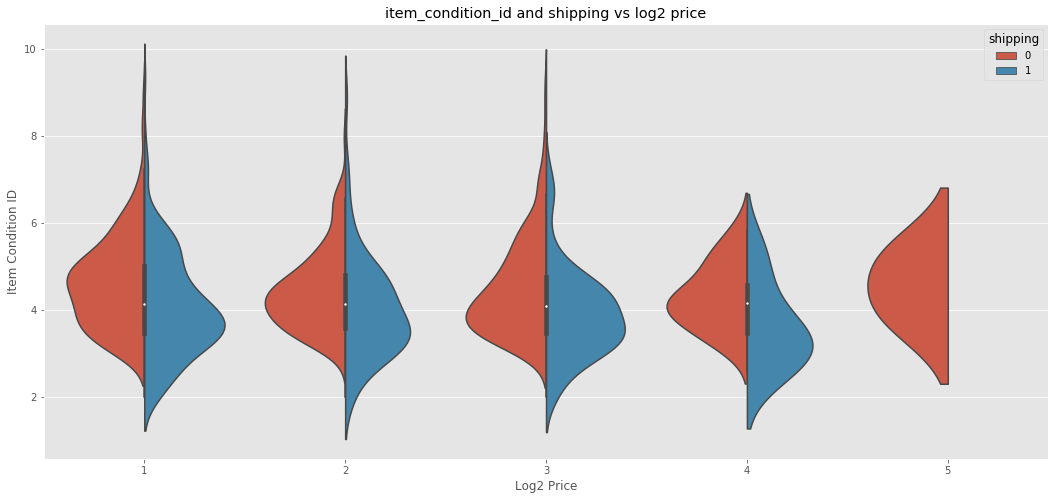

In [14]:
f,ax=plt.subplots(figsize=(18,8))
sns.violinplot(train.item_condition_id, price.log_price, hue=train.shipping, split=True)
ax.set_title('item_condition_id and shipping vs log2 price')
ax.set_xlabel("Log2 Price")
ax.set_ylabel("Item Condition ID")
plt.show()

### Data Preprocessing

In [15]:
BrandMinNum = 2
NUM_BRANDS = 250

In [16]:
df = pd.concat([train, test], 0)
nrow_train = train.shape[0]
Y_train = np.log1p(train["price"])

del train
gc.collect() # release usage memory (df_train)

print(df.memory_usage(deep = True))

Index                 15984
brand_name           103607
category_name        174313
item_condition_id     15984
item_description     459804
name                 167342
price                 15984
shipping              15984
test_id               15984
train_id              15984
dtype: int64


In [17]:
df["category_name"] = df["category_name"].fillna("Other").astype("category")
df["brand_name"] = df["brand_name"].fillna("unknown")

# pop_brands = df["brand_name"].value_counts().index[:NUM_BRANDS]
brand_count = df["brand_name"].value_counts()
pop_brands = brand_count[brand_count > BrandMinNum].index
df.loc[~df["brand_name"].isin(pop_brands), "brand_name"] = "Other"

df["item_description"] = df["item_description"].fillna("None")
df["item_condition_id"] = df["item_condition_id"].astype("category")
df["brand_name"] = df["brand_name"].astype("category")

print(df.memory_usage(deep = True))

Index                 15984
brand_name            11178
category_name         47794
item_condition_id      2198
item_description     459804
name                 167342
price                 15984
shipping              15984
test_id               15984
train_id              15984
dtype: int64


### Brand Name

In [18]:
print("Brand encoders")
print("Convert 'brand_name' to sparse matrix")
vect_brand = LabelBinarizer(sparse_output=True)
X_brand = vect_brand.fit_transform(df["brand_name"])

print("Shape={}".format(X_brand.toarray().shape))

Brand encoders
Convert 'brand_name' to sparse matrix
Shape=(1998, 99)


<br>
#### brand vs price
* there are many outliers
    * use <b>median price</b> rather than average price on each brand
<br>

In [19]:
brand_price = defaultdict(list)
for brand, price in zip(df.brand_name[:nrow_train], df.price[:nrow_train]):
    brand_price[brand].append(price)

fig = helper.brand_box_plot(brand_price, show=50)
iplot(fig)

In [20]:
brand_price_median_dict = defaultdict(int)
for brand, price in brand_price.items():
    brand_price_median_dict[brand] = helper.median(price)
    
brand_price_median = helper.brand_dict2Series(brand_price_median_dict)

In [21]:
fig = helper.brand_median_price_plot(brand_price_median, top_n=50)
iplot(fig)

### Category Name

In [22]:
print("Category Encoders")
print("Convert 'category_name' to sparse matrix (token frequency)\n")
unique_categories = pd.Series("/".join(df["category_name"].unique().astype("str")).split("/")).unique()
count_category = CountVectorizer()
X_category = count_category.fit_transform(df["category_name"])
X_category_name = count_category.get_feature_names()

print("There are {} uniq categories.".format(len(unique_categories)))
print("Shape={}".format(X_category.toarray().shape))


Category Encoders
Convert 'category_name' to sparse matrix (token frequency)

There are 368 uniq categories.
Shape=(1998, 437)


In [23]:
category_num = Series(np.sum(X_category.toarray(), axis=0), index=X_category_name)
category_num.sort_values(ascending=False)[:5]

women          1017
beauty          299
accessories     255
makeup          243
kids            240
dtype: int64

<br><br><br><br>
## Get Features
* `train_id` or `test_id` - the id of the listing <br>
* `name` - the title of the listing. 
Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm] <br>
* `item_condition_id` - the condition of the items provided by the seller <br>
* `category_name` - category of the listing <br>
* `brand_name` <br>
* `price` - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict. <br>
* `shipping` - 1 if shipping fee is paid by seller and 0 by buyer <br>
* `item_description` - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm]

In [24]:
df.head(3)

,brand_name,category_name,item_condition_id,item_description,name,price,shipping,test_id,train_id
0,unknown,Men/Tops/T-shirts,3,No description yet,MLB Cincinnati Reds T Shirt Size XL,10.0,1,NaN,0.0
1,Other,Electronics/Computers & Tablets/Components & P...,3,This keyboard is in great condition and works ...,Razer BlackWidow Chroma Keyboard,52.0,0,NaN,1.0
2,Target,Women/Tops & Blouses/Blouse,1,Adorable top with a hint of lace and a key hol...,AVA-VIV Blouse,10.0,1,NaN,2.0


In [25]:
print("Dummy Encoders")
print("Convert 'item_condition_id' + 'shipping' to sparse matrix")
X_dummies = scipy.sparse.csr_matrix(pd.get_dummies(df[[
    "item_condition_id", "shipping"]], sparse = True).values)

print("Shape={}".format(X_dummies.toarray().shape))

Dummy Encoders
Convert 'item_condition_id' + 'shipping' to sparse matrix
Shape=(1998, 6)


In [26]:
X = scipy.sparse.hstack((X_dummies, 
#                          X_descp,
                         X_brand,
                         X_category,
#                          X_name
                        )).tocsr()

print([X_dummies.shape, X_category.shape, 
#        X_name.shape, X_descp.shape, 
       X_brand.shape])
print("stacked data shape={}".format(X.shape))

[(1998, 6), (1998, 437), (1998, 99)]
stacked data shape=(1998, 542)


### Features
* item_condition_id [one hot]
* shipping [one hot]
* brand [brand_median_price]

In [27]:
X_train = X[:nrow_train]
X_test = X[nrow_train:]

X_train, X_eval, y_train, y_eval = train_test_split(
    X_train, Y_train, test_size=0.1, random_state=42)

In [28]:
print("train length: {}".format(X_train.shape[0]))
print("eval length: {}".format(X_eval.shape[0]))
print("feature num: {}".format(X_train.shape[1]))

train length: 899
eval length: 100
feature num: 542


In [29]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train.toarray().astype('float32')},
    y=y_train.as_matrix(),
    num_epochs=None,
    shuffle=True)

In [30]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_eval.toarray().astype('float32')},
    y=y_eval.as_matrix(),
    num_epochs=1,
    shuffle=False)

In [31]:
some_data = X_eval.toarray().astype('float32')[0:9]

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": some_data},
    num_epochs=1,
    shuffle=False)

In [32]:
feature_x = tf.feature_column.numeric_column("x", shape=X_train.shape[1])

feature_columns = [feature_x]

num_hidden_units = [500, 150, 30, 150, 500]

model = tf.estimator.DNNRegressor(feature_columns=feature_columns,
                                   hidden_units=num_hidden_units,
                                   activation_fn=tf.nn.relu,
                                   optimizer=tf.train.ProximalAdagradOptimizer(
                                             learning_rate=0.1,
                                             l1_regularization_strength=0.001),
                                   model_dir="./checkpoints/")


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_keep_checkpoint_max': 5, '_model_dir': './checkpoints/', '_session_config': None, '_save_checkpoints_secs': 600, '_tf_random_seed': 1, '_log_step_count_steps': 100, '_save_summary_steps': 100}


In [33]:
model.train(input_fn=train_input_fn, steps=2000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-1
INFO:tensorflow:Saving checkpoints for 2 into ./checkpoints/model.ckpt.
INFO:tensorflow:loss = 1.00464e+08, step = 2
INFO:tensorflow:global_step/sec: 42.4881
INFO:tensorflow:loss = 40.0438, step = 102 (2.351 sec)
INFO:tensorflow:global_step/sec: 50.3466
INFO:tensorflow:loss = 46.0241, step = 202 (1.986 sec)
INFO:tensorflow:global_step/sec: 51.1009
INFO:tensorflow:loss = 39.4094, step = 302 (1.958 sec)
INFO:tensorflow:global_step/sec: 51.7713
INFO:tensorflow:loss = 27.0036, step = 402 (1.931 sec)
INFO:tensorflow:global_step/sec: 49.6123
INFO:tensorflow:loss = 27.8458, step = 502 (2.017 sec)
INFO:tensorflow:global_step/sec: 42.1102
INFO:tensorflow:loss = 37.0075, step = 602 (2.375 sec)
INFO:tensorflow:global_step/sec: 48.6181
INFO:tensorflow:loss = 28.3169, step = 702 (2.056 sec)
INFO:tensorflow:global_step/sec: 50.6124
INFO:tensorflow:loss = 30.3081, step = 802 (1.976 sec)
IN

In [34]:
result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Starting evaluation at 2017-12-27-07:21:35
INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-2001
INFO:tensorflow:Finished evaluation at 2017-12-27-07:21:36
INFO:tensorflow:Saving dict for global step 2001: average_loss = 0.662033, global_step = 2001, loss = 66.2033


In [35]:
result

{'average_loss': 0.66203254, 'global_step': 2001, 'loss': 66.203255}

In [36]:
predictions = model.predict(input_fn=predict_input_fn)
pred = [p['predictions'] for p in predictions]

INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-2001


In [37]:
pred = np.array(pred, dtype='float32').squeeze()
print("Predict Result: {}\n".format(pred))
print("Real: {}".format(list(y_eval[0:9])))

Predict Result: [ 2.36693668  3.45942354  2.07017469  2.91663551  2.17051601  2.57548714
  3.26810431  3.04421496  2.21586704]

Real: [2.5649493574615367, 2.3978952727983707, 3.1354942159291497, 1.9459101490553132, 2.8903717578961645, 2.3978952727983707, 2.8332133440562162, 3.5553480614894135, 1.9459101490553132]


<br>
### Test

In [38]:
print("X_test.shape = {}".format(X_test.shape))
X_test.toarray().astype('float32')

X_test.shape = (999, 542)


array([[ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 1.,  1.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [39]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test.toarray().astype('float32')},
    num_epochs=1,
    shuffle=False)

In [40]:
predictions = model.predict(input_fn=predict_input_fn)
pred = [p['predictions'] for p in predictions]
pred_result = np.array(pred, dtype='float32').squeeze()

INFO:tensorflow:Restoring parameters from ./checkpoints/model.ckpt-2001


In [41]:
test["price"] = np.expm1(pred_result)
test[["test_id", "price"]].to_csv("dnn_result.csv", index = False)

In [42]:
test[["test_id", "price"]].head(5)

,test_id,price
0,0,8.460262
1,1,2.238732
2,2,127.070396
3,3,17.638468
4,4,13.075456
